# Analysis of Hate Groups Data
We study the SLP data of Hate groups particularly focusing on **Anti-immigrant groups**.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [6]:
hg = pd.read_csv('data/splc-hate-groups.csv')
hg.head(10)

,Title,City,State,Group,Ideology,Headquarters,Statewide,Year
0,American Border Patrol,Sierra Vista,Arizona,American Border Patrol/American Patrol,Anti-Immigrant,Yes,NaN,2019
1,American Immigration Control Foundation/Americ...,Monterey,Virginia,NaN,Anti-Immigrant,Yes,NaN,2019
2,Americans for Legal Immigration (ALIPAC),Raleigh,North Carolina,NaN,Anti-Immigrant,Yes,NaN,2019
3,AZ Patriots,NaN,Arizona,NaN,Anti-Immigrant,Yes,Yes,2019
4,Californians for Population Stabilization,Ventura,California,NaN,Anti-Immigrant,NaN,NaN,2019
5,Center for Immigration Studies,Washington,District of Columbia,Center for Immigration Studies,Anti-Immigrant,Yes,NaN,2019
6,Colorado Alliance for Immigration Reform,Lakewood,Colorado,NaN,Anti-Immigrant,Yes,NaN,2019
7,Federation for American Immigration Reform,Washington,District of Columbia,Federation for American Immigration Reform,Anti-Immigrant,Yes,NaN,2019
8,Floridians for Immigration Enforcement,Pompano Beach,Florida,NaN,Anti-Immigrant,NaN,NaN,2019
9,Help Save Maryland,Monkton,Maryland,NaN,Anti-Immigrant,Yes,NaN,2019


## 1. Looking at Hate Groups Over Time

In [114]:
counts = hg.groupby(['Year', 'Ideology']).size().reset_index(name='count')
top3 = counts.sort_values(by=['Year','count'], ascending=[True, False]).groupby('Year').head(3)

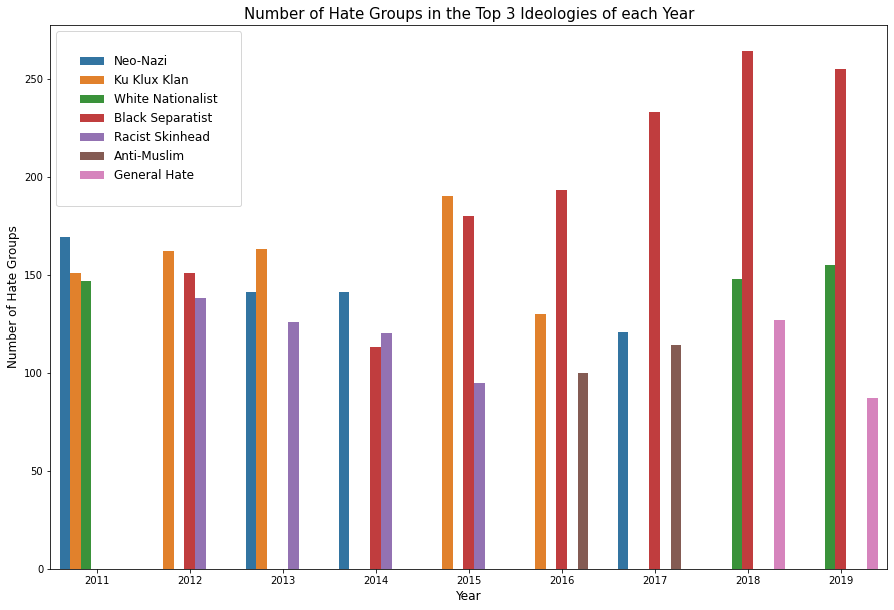

In [143]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.barplot(x="Year", y="count", hue='Ideology', data=top3[top3.Year > 2010])
ax.legend(loc='upper left', borderpad=2, prop={'size':12})
plt.title('Number of Hate Groups in the Top 3 Ideologies of each Year', size=15)
plt.ylabel('Number of Hate Groups', size=12)
plt.xlabel('Year', size=12)
plt.show()

### 1.1 Anti-Immigrant Groups

In [9]:
counts_im = counts[counts.Ideology == 'Anti-Immigrant']

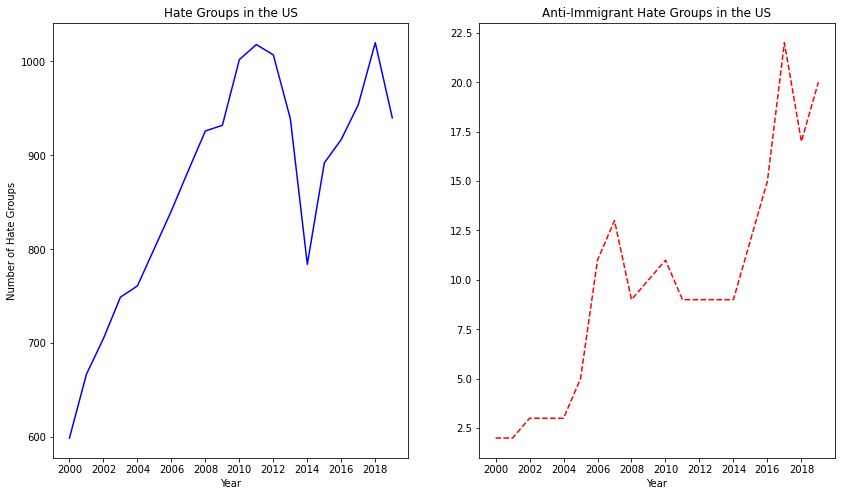

In [148]:
fig, ax = plt.subplots(figsize=(14,8), ncols=2, nrows=1)
ax1 = sns.lineplot(x="Year", y="count", 
                   data=counts.groupby('Year').agg({'count':'sum'}).reset_index(), 
                  color='blue', ax=ax[0])
freq = int(2)
ax1.set_xticks(counts.groupby('Year').agg({'count':'sum'}).reset_index().Year[::freq])
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Hate Groups')
ax1.title.set_text('Hate Groups in the US')


ax2 = sns.lineplot(x="Year", y="count", data=counts_im, color='red', ax=ax[1])
ax2.set_xticks(counts_im.Year[::freq])
ax2.lines[0].set_linestyle("--")
ax2.set_xlabel('Year')
ax2.set_ylabel('')
ax2.title.set_text('Anti-Immigrant Hate Groups in the US')

plt.show()

In [11]:
hg_im = hg[hg.Ideology == 'Anti-Immigrant']

In [12]:
us = gpd.read_file('data/shapes/tl_2017_us_state.shp')
us = us[['STUSPS', 'GEOID', 'NAME', 'REGION', 'geometry']]
print(us.shape)
non_states = ['Commonwealth of the Northern Mariana Islands', 'Guam','Puerto Rico', 
              'American Samoa', 'United States Virgin Islands']
us = us.drop(us[us.apply(lambda x: True if x['NAME'] in non_states else False, axis=1)].index)
us.set_index('GEOID', inplace=True)
us_lim = us.drop(us[us.apply(lambda x: True if x['NAME'] in ['Alaska', 'Hawaii'] else False, axis=1)].index)

(56, 5)


In [95]:
counts = hg.groupby(['State', 'Year', 'Ideology']).size().reset_index(name='count')

In [96]:
counts_g = us_lim[['NAME', 'geometry']].merge(counts[(counts.Year == 2019) & 
                                                     (counts.Ideology == 'Anti-Immigrant')], 
                                              right_on='State', left_on='NAME', 
                                              how='left').fillna({'count':0, 'Year':2019, 'Ideology':'Anti-Immigrant'})
counts_g['State'] = counts_g['NAME']
counts_g.drop(columns=['NAME'], inplace=True)

In [97]:
pop = pd.read_csv('data/population.csv')
counts_g = counts_g.merge(pop[pop.Year==2019][['State', 'population']], on=['State'])

In [100]:
counts_g['count_norm']= counts_g['count']*1000000/counts_g['population']

### 1.2 Anti-Immigrant groups in state level

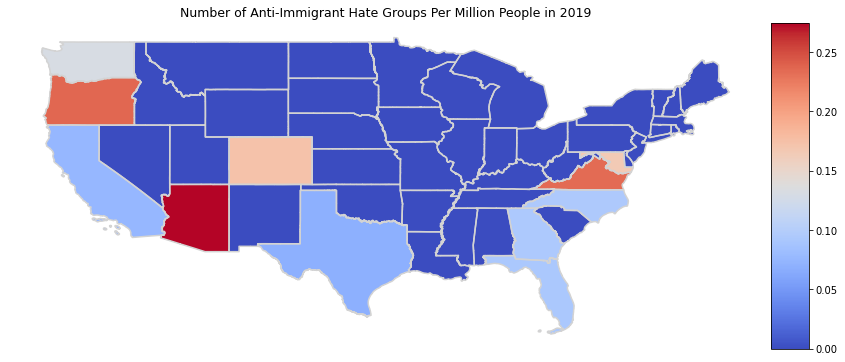

In [112]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(15,6))
plt.title('Number of Anti-Immigrant Hate Groups Per Million People in 2019', size=12.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
counts_g[counts_g.State != 'District of Columbia'].plot(column='count_norm',
                                                       cmap='coolwarm',legend=True,ax=ax, cax=cax)
counts_g.boundary.plot(color='lightgrey',ax =ax)
ax.axis('off')
plt.show()